# Bayesian Optimization on a Sphere Manifold $\mathbb{S}^2$

This notebooks illustrates the application of Bayesian optimization (BO) on a sphere manifold. 
To run it, you need to have [BoTorch](https://botorch.org/) installed.

References:

[1] N. Jaquier, V. Borovitskiy, A. Smolensky, A. Terenin, T. Asfour, and L. Rozo. Geometry-aware Bayesian Optimization in Robotics using Riemannian Matérn Kernels. In Conference on Robot Learning (CoRL), 2021. https://arxiv.org/pdf/2111.01460.pdf

[2] N. Jaquier, L. Rozo, S. Calinon, and M. Bürger. Bayesian Optimization Meets Riemannian Manifolds in Robot Learning. In Conference on Robot Learning (CoRL), 2019. https://arxiv.org/pdf/1910.04998.pdf

In [1]:
import numpy as np
import random
import torch
import gpytorch
import botorch
import warnings

In [2]:
import geometric_kernels.torch
from geometric_kernels.spaces.hypersphere import Hypersphere
from geometric_kernels.kernels.geometric_kernels import MaternKarhunenLoeveKernel
from geometric_kernels.frontends.pytorch.gpytorch import GPytorchGeometricKernel

INFO: Using numpy backend


We first set the numpy and pytorch seeds for reproducibility.

In [3]:
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

We initialize a sphere manifold $\mathbb{S}^2$.

In [4]:
dimension = 3
hypersphere = Hypersphere(dim=dimension-1)

Define the function to optimize. 

Here we use the Ackley function (see, e.g., https://www.sfu.ca/~ssurjano/ackley.html).
The function is defined on the tangent space of the base point $(1, 0, 0, ...)$ and projected to the manifold via the exponential map. The value of the function is therefore computed by projecting the point on the manifold to the tangent space of the base point and by computing the value of the Ackley function in this Euclidean space.
This requires the logarithmic map on the sphere, also defined below.

In [5]:
def logmap(x, x0):
    """
    This functions maps a point lying on the sphere manifold into the tangent space of a second point of the manifold.

    Parameters
    ----------
    :param x: point on the sphere manifold
    :param x0: basis point of the tangent space where x will be mapped

    Returns
    -------
    :return: u: vector in the tangent space of x0
    """
    if x0.ndim < 2:
        x0 = x0[None]

    if x.ndim < 2:
        x = x[None]

    theta = torch.arccos(torch.maximum(torch.minimum(torch.inner(x0, x), torch.ones(1)), -torch.ones(1)))
    u = (x - x0 * torch.cos(theta)) * theta / torch.sin(theta)

    u[:, torch.where(theta[0] < 1e-16)[0]] = 0.

    return u

def ackley_function_sphere(x):
    # Data to numpy
    if x.ndim < 2:
        x = x[None]

    # Dimension of the manifold
    dimension = x.shape[-1]

    # Projection in tangent space of the mean.
    # The base is fixed at (1, 0, 0, ...) for simplicity. Therefore, the tangent plane is aligned with the axis x.
    # The first coordinate of x_proj is always 0, so that vectors in the tangent space can be expressed in a dim-1
    # dimensional space by simply ignoring the first coordinate.
    base = torch.zeros((1, dimension), dtype=x.dtype)
    base[0, 0] = 1.
    x_proj = logmap(x, base)[0]

    # Remove first dim
    x_proj_red = x_proj[1:]
    reduced_dimension = dimension - 1

    # Ackley function parameters
    a = 20
    b = 0.2
    c = 2 * np.pi

    # Ackley function
    aexp_term = -a * torch.exp(-b * torch.sqrt(torch.sum(x_proj_red ** 2) / reduced_dimension))
    expcos_term = - torch.exp(torch.sum(torch.cos(c * x_proj_red) / reduced_dimension))
    y = aexp_term + expcos_term + a + np.exp(1.)

    return y[None, None]


## Initialization

Generate 5 random data locations on the sphere to be used as initial design for BO.

In [6]:
nb_data_init = 5

x_data = torch.tensor(hypersphere.random_point(nb_data_init))
y_data = torch.zeros(nb_data_init, dtype=torch.float64)
for n in range(nb_data_init):
    y_data[n] = ackley_function_sphere(x_data[n])

print('Inputs:', x_data)
print('Outputs: ', y_data)

Inputs: tensor([[ 0.2453, -0.6197,  0.7455],
        [-0.2639, -0.6081,  0.7487],
        [ 0.8036, -0.5950,  0.0147],
        [-0.8280,  0.4246,  0.3662],
        [ 0.4219, -0.8945, -0.1478]], dtype=torch.float64)
Outputs:  tensor([3.9497, 6.4574, 3.2544, 7.5566, 3.9296], dtype=torch.float64)


## Definition of the BO surrogate model
Here we use a Gaussian process with a Matérn kernel on $\mathbb{S}^2$, as by [1].

The kernel has three positive real hyperparameters: variance $\sigma^2$, length scale $\kappa$ and smoothness $\nu$.
Defining a Gaussian process model also requires a likelihood noise hyperparameter $\sigma_n^2$.

We use the $\operatorname{Gamma}(2.0, 0.15)$ prior for $\sigma$, the square root of $\sigma^2$, and $\operatorname{Gamma}(1.1, 0.05)$ prior for $\sigma_n^2$.

We first define the kernel.

In [7]:
_TRUNCATION_LEVEL = 10
base_kernel = GPytorchGeometricKernel(MaternKarhunenLoeveKernel(hypersphere, _TRUNCATION_LEVEL))
kernel = gpytorch.kernels.ScaleKernel(base_kernel,
                                      outputscale_prior=gpytorch.priors.torch_priors.GammaPrior(2.0, 0.15))

The number of eigenfunctions requested does not lead to complete levels of spherical harmonics. We have thus increased the number to 16, which includes all spherical harmonics up to degree 4 (excl.)
The number of eigenfunctions requested does not lead to complete levels of spherical harmonics. We have thus increased the number to 16, which includes all spherical harmonics up to degree 4 (excl.)


We then define the likelihood of the Gaussian process.

In [8]:
noise_prior = gpytorch.priors.torch_priors.GammaPrior(1.1, 0.05)
noise_prior_mode = (noise_prior.concentration - 1) / noise_prior.rate
lik_fct = gpytorch.likelihoods.gaussian_likelihood.GaussianLikelihood(noise_prior=noise_prior,
                                                                      noise_constraint=
                                                                      gpytorch.constraints.GreaterThan(1e-8),
                                                                      initial_value=noise_prior_mode)

We finally initialize the GP model, as well as the marginal likelihood function that will be used to optimize its parameters.

In [9]:
model = botorch.models.SingleTaskGP(x_data, y_data[:, None], covar_module=kernel, likelihood=lik_fct)
mll_fct = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

## Bayesian optimization loop

In [10]:
new_best_f, index = y_data.min(0)
best_x = [x_data[index]]
best_f = [new_best_f]

We define the bounds for the optimization of the acquisition function, as well as the constraints that must be satisfied by candidate points on the sphere.

In [11]:
bounds = torch.stack([-torch.ones(dimension, dtype=torch.float64), torch.ones(dimension, dtype=torch.float64)])

def upper_constraint(x):
    return 1.0 - torch.linalg.norm(x, dim=-1)

def lower_constraint(x):
    return torch.linalg.norm(x, dim=-1) - 1.0

We can now run our BO loop. At each iteration, we first optimize our GP model, then we define the acquisition function, and select the new candidate point as the point maximizing the acquisition function. 

Notice that, for the sake of simplicity, we here use a constrained optimization on the sphere to guarantee that our new candidate point belongs to the sphere manifold. However, for a fully geometry-aware BO loop, Riemannian optimization should be used to optimize the acquisition function on the manifold, see [1], [2] for details, and https://github.com/NoemieJaquier/MaternGaBO for an implementation.

In [12]:
n_iters = 25
for iteration in range(n_iters):
    # Fit GP model
    botorch.fit_gpytorch_model(mll=mll_fct)

    # Define the acquisition function
    acq_fct = botorch.acquisition.ExpectedImprovement(model=model, best_f=best_f[-1], maximize=False)
    
    # Initial conditions to optimize the acquisition function
    batch_initial_conditions = torch.tensor(hypersphere.random_point(100))
    batch_initial_conditions /= torch.linalg.norm(batch_initial_conditions, dim=-1)[:, None]


    # Get new candidate
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        new_x, acq_new_x = botorch.optim.optimize_acqf(acq_fct, bounds=bounds, q=1,
                                                       num_restarts=5, raw_samples=100,
                                                       nonlinear_inequality_constraints=[upper_constraint,
                                                                                         lower_constraint],
                                                       batch_initial_conditions=batch_initial_conditions[:, None])
    # Get new observation
    new_y = ackley_function_sphere(new_x)[0]

    # Update training points
    x_data = torch.cat((x_data, new_x))
    y_data = torch.cat((y_data, new_y))

    # Update best observation
    new_best_f, index = y_data.min(0)
    best_x.append(x_data[index])
    best_f.append(new_best_f)

    # Update the model
    model.set_train_data(x_data, y_data, strict=False)  # strict False necessary to add datapoints

    print("Iteration " + str(iteration) + "\t Best f " + str(new_best_f.item()))

Iteration 0	 Best f 3.2543758676565138
Iteration 1	 Best f 3.2543758676565138
Iteration 2	 Best f 1.199826977720083
Iteration 3	 Best f 1.199826977720083
Iteration 4	 Best f 1.199826977720083
Iteration 5	 Best f 1.199826977720083
Iteration 6	 Best f 1.199826977720083
Iteration 7	 Best f 0.5187739891185896
Iteration 8	 Best f 0.5187739891185896
Iteration 9	 Best f 0.5187739891185896
Iteration 10	 Best f 0.5187739891185896
Iteration 11	 Best f 0.5187739891185896
Iteration 12	 Best f 0.5187739891185896
Iteration 13	 Best f 0.39601370512681955
Iteration 14	 Best f 0.39601370512681955
Iteration 15	 Best f 0.39601370512681955
Iteration 16	 Best f 0.39601370512681955
Iteration 17	 Best f 0.39601370512681955
Iteration 18	 Best f 0.3095212015135691
Iteration 19	 Best f 0.3095212015135691
Iteration 20	 Best f 0.3095212015135691
Iteration 21	 Best f 0.3095212015135691
Iteration 22	 Best f 0.3095212015135691
Iteration 23	 Best f 0.3095212015135691
Iteration 24	 Best f 0.3095212015135691


In [13]:
x_eval = x_data.cpu().numpy()
y_eval = y_data.cpu().numpy()[:, None]
best_x_np = np.array([x.cpu().detach().numpy() for x in best_x])
best_f_np = np.array([f.cpu().detach().numpy() for f in best_f])[:, None]

# Results


In [14]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from mpl_toolkits.mplot3d import Axes3D

We set the true minimum value of the objective function to evaluate the performance of the BO.

In [15]:
true_min_x = np.zeros((1, dimension))
true_min_x[0, 0] = 1.
true_min_value = 0.0

We display the candidate points on the sphere evaluated in the BO loop. Their color indicate the value of the function (yellow is low, purple is high). The best candidate is displayed as a red diamond, and the true minimum as a blue cross.

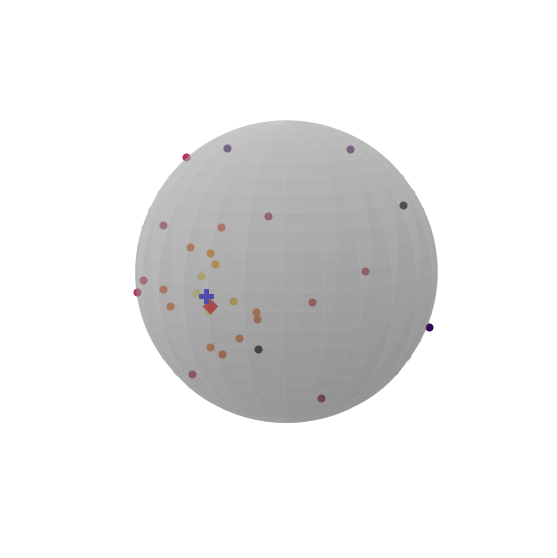

In [16]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

# Make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# Make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] = (1, 1, 1, 0)
ax.yaxis._axinfo["grid"]['color'] = (1, 1, 1, 0)
ax.zaxis._axinfo["grid"]['color'] = (1, 1, 1, 0)

# Remove axis
ax._axis3don = False

# Initial view
# ax.view_init(elev=10, azim=-20.)  # (default: elev=30, azim=-60)
ax.view_init(elev=10, azim=30.)  # (default: elev=30, azim=-60)

# Plot sphere
n_elems = 100
r = 0.99
u = np.linspace(0, 2 * np.pi, n_elems)
v = np.linspace(0, np.pi, n_elems)

x = r * np.outer(np.cos(u), np.sin(v))
y = r * np.outer(np.sin(u), np.sin(v))
z = r * np.outer(np.ones(np.size(u)), np.cos(v))

ax.plot_surface(x, y, z, rstride=4, cstride=4, color=[0.8, 0.8, 0.8], linewidth=0, alpha=0.4)

lim = 1.1
ax.set_xlim3d([-lim, lim])
ax.set_ylim3d([-lim, lim])
ax.set_zlim3d([-0.75*lim, 0.75*lim])

# Plot evaluated points
max_colors = np.max(y_eval - true_min_value)
for n in range(x_eval.shape[0]):
    ax.scatter(x_eval[n, 0], x_eval[n, 1], x_eval[n, 2], s=50,
               c=pl.cm.inferno(1. - (y_eval[n] - true_min_value) / max_colors))

# Plot true minimum
ax.scatter(true_min_x[0, 0], true_min_x[0, 1], true_min_x[0, 2], s=200, c='b', marker='P')

# Plot BO minimum
ax.scatter(best_x_np[-1][0], best_x_np[-1][1], best_x_np[-1][2], s=100, c='r', marker='D')

plt.show()

We finally display the distance between consecutive candidate points on the sphere, and the convergence plot of our BO algorithm.

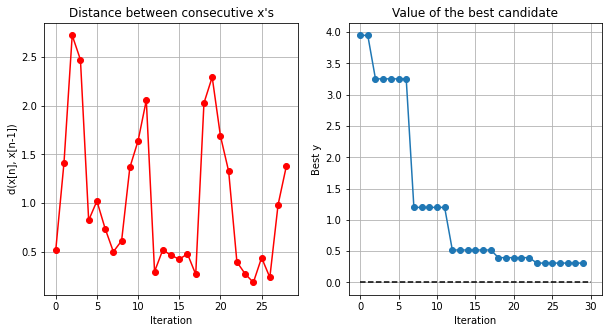

In [17]:
def sphere_distance(x, y):
    if np.ndim(x) < 2:
        x = x[:, None]
    if np.ndim(y) < 2:
        y = y[:, None]

    # Compute the inner product (should be [-1,1])
    inner_product = np.dot(x.T, y)
    inner_product = np.max(np.min(inner_product, 1), -1)
    return np.arccos(inner_product)

# Compute distances between consecutive x's and best evaluation for each iteration
neval = x_eval.shape[0]
distances = np.zeros(neval-1)
for n in range(neval-1):
    distances[n] = sphere_distance(x_eval[n + 1, :], x_eval[n, :])

Y_best = np.ones(neval)
for i in range(neval):
    Y_best[i] = y_eval[:(i + 1)].min()

# Plot distances between consecutive x's
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(np.array(range(neval - 1)), distances, '-ro')
plt.xlabel('Iteration')
plt.ylabel('d(x[n], x[n-1])')
plt.title('Distance between consecutive x\'s')
plt.grid(True)

# Plot value of the best candidate
plt.subplot(1, 2, 2)
plt.plot(np.array(range(neval)), Y_best, '-o')
plt.hlines(true_min_value, 0, neval, 'k', '--')
plt.title('Value of the best candidate')
plt.xlabel('Iteration')
plt.ylabel('Best y')
plt.grid(True)

plt.show()